# DQN Experiments

This notebook evaluates the DQN (Deep Q-Network) agent on the TestEnv environment.
We analyze convergence, cumulative reward, and policy stability under different hyperparameter settings. <br>

All algorithm code is implemented in `src/models/DQNN.py`. <br>
This notebook only shows the direct implementation of an experiment and analysis of the results.

We perform the following experiments:

- DQN with reward shaping and 5 bins <br>


In [1]:
# We import the necessary libraries and modules
import sys
import os

project_root = os.path.abspath("..")
sys.path.append(project_root)

from stable_baselines3 import DQN
from src.env.TestEnv import HydroElectric_Test
from src.models.DQN import DQNWrapper
from src.utils.visualizations import *
import optuna
import numpy as np
import random


### Hyperparameter optimization

We want to optimize the hyperparameters of the model first. To do this, we set a random seed and perform an optuna study.


In [2]:
# We set a random seed for reproducibility
SEED = 5
np.random.seed(SEED)
random.seed(SEED)


In [3]:
# We set the experiment configurations
NUM_ACTIONS = 5
REWARD_SHAPING = True

TRAIN_CONFIG = {
    "learning_rate": 1e-4,
    "batch_size": 128,
    "exploration_final_eps": 0.05,
    "buffer_size": 50000,
    "learning_starts": 5000,
    "train_freq": 4,
    "gradient_steps": 1,
    "target_update_interval": 1000,
    "gamma": 0.99,
    "exploration_fraction": 0.3,
    "exploration_initial_eps": 1.0,
    "total_timesteps": 100000,
}

parameter_dict = {
    'learning_rate': (1e-5, 1e-3),
    'batch_size': [32, 64, 128, 256],
    'exploration_final_eps': (0.01, 0.1),
}


In [4]:
# We initialize the training environment
train_path = os.path.abspath("data/train.xlsx")
train_env_raw = HydroElectric_Test(train_path)
train_env = DQNWrapper(train_env_raw, reward_shape=REWARD_SHAPING, num_actions=NUM_ACTIONS)
train_env.reset(seed=SEED)

# We initialize the validation environment
val_path = os.path.abspath("data/validate.xlsx")
val_env_raw = HydroElectric_Test(val_path)
val_env = DQNWrapper(val_env_raw, reward_shape=REWARD_SHAPING, num_actions=NUM_ACTIONS)
val_env.reset(seed=SEED)


(array([0.5       , 0.00440147, 0.        , 0.6666667 , 0.        ],
       dtype=float32),
 {})

In [5]:
def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_float("learning_rate", parameter_dict["learning_rate"][0], parameter_dict["learning_rate"][1], log=True)
    batch_size = trial.suggest_categorical("batch_size", parameter_dict["batch_size"])
    exploration_final_eps = trial.suggest_float("exploration_final_eps", parameter_dict["exploration_final_eps"][0], parameter_dict["exploration_final_eps"][1], log=True)

    # Update train config with suggested hyperparameters
    TRAIN_CONFIG["learning_rate"] = learning_rate
    TRAIN_CONFIG["batch_size"] = int(batch_size)
    TRAIN_CONFIG["exploration_final_eps"] = exploration_final_eps

    # Create and train model
    policy_kwargs = dict(net_arch=[256, 256, 128])
    model = DQN(
        "MlpPolicy",
        train_env,
        verbose=0,
        learning_rate=TRAIN_CONFIG["learning_rate"],
        buffer_size=TRAIN_CONFIG["buffer_size"],
        learning_starts=TRAIN_CONFIG["learning_starts"],
        batch_size=TRAIN_CONFIG["batch_size"],
        train_freq=TRAIN_CONFIG["train_freq"],
        gradient_steps=TRAIN_CONFIG["gradient_steps"],
        target_update_interval=TRAIN_CONFIG["target_update_interval"],
        gamma=TRAIN_CONFIG["gamma"],
        exploration_fraction=TRAIN_CONFIG["exploration_fraction"],
        exploration_initial_eps=TRAIN_CONFIG["exploration_initial_eps"],
        exploration_final_eps=TRAIN_CONFIG["exploration_final_eps"],
        policy_kwargs=policy_kwargs,
    )

    # Train the model
    model.learn(total_timesteps=TRAIN_CONFIG["total_timesteps"], log_interval=10)

    # Evaluate on validation environment
    val_env.reset(seed=SEED)
    val_env.reward_shape = False  # Disable reward shaping for evaluation
    
    obs, _ = val_env.reset(seed=SEED)
    obs = np.array(obs, dtype=np.float32)
    done = False
    episode_rewards = []
    
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        action = int(action)
        obs, reward, terminated, truncated, _ = val_env.step(action)
        done = terminated or truncated
        episode_rewards.append(reward)
        obs = np.array(obs, dtype=np.float32)
    
    total_reward = sum(episode_rewards)
    return total_reward


### Experiment 1: 5 Bins / Reward Shaping


In [13]:
# Run Optuna study for hyperparameter optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print("Best hyperparameters: ", study.best_params)


[I 2026-01-28 21:07:48,937] A new study created in memory with name: no-name-db7d8220-5de4-49ce-b439-47c254bb3772
[I 2026-01-28 21:08:43,189] Trial 0 finished with value: 57065.78937684518 and parameters: {'learning_rate': 0.0005515459875374307, 'batch_size': 128, 'exploration_final_eps': 0.01547493293344383}. Best is trial 0 with value: 57065.78937684518.
[I 2026-01-28 21:09:40,750] Trial 1 finished with value: 51857.74282453631 and parameters: {'learning_rate': 0.000526426699784957, 'batch_size': 128, 'exploration_final_eps': 0.023734117113630777}. Best is trial 0 with value: 57065.78937684518.
[I 2026-01-28 21:10:38,258] Trial 2 finished with value: 19061.029104561134 and parameters: {'learning_rate': 0.00024430338625906593, 'batch_size': 128, 'exploration_final_eps': 0.024068450548678077}. Best is trial 0 with value: 57065.78937684518.
[I 2026-01-28 21:11:32,554] Trial 3 finished with value: 8.740716992568 and parameters: {'learning_rate': 1.9362383121171407e-05, 'batch_size': 64, 

Best hyperparameters:  {'learning_rate': 0.0009638038112182319, 'batch_size': 128, 'exploration_final_eps': 0.0388671486044139}


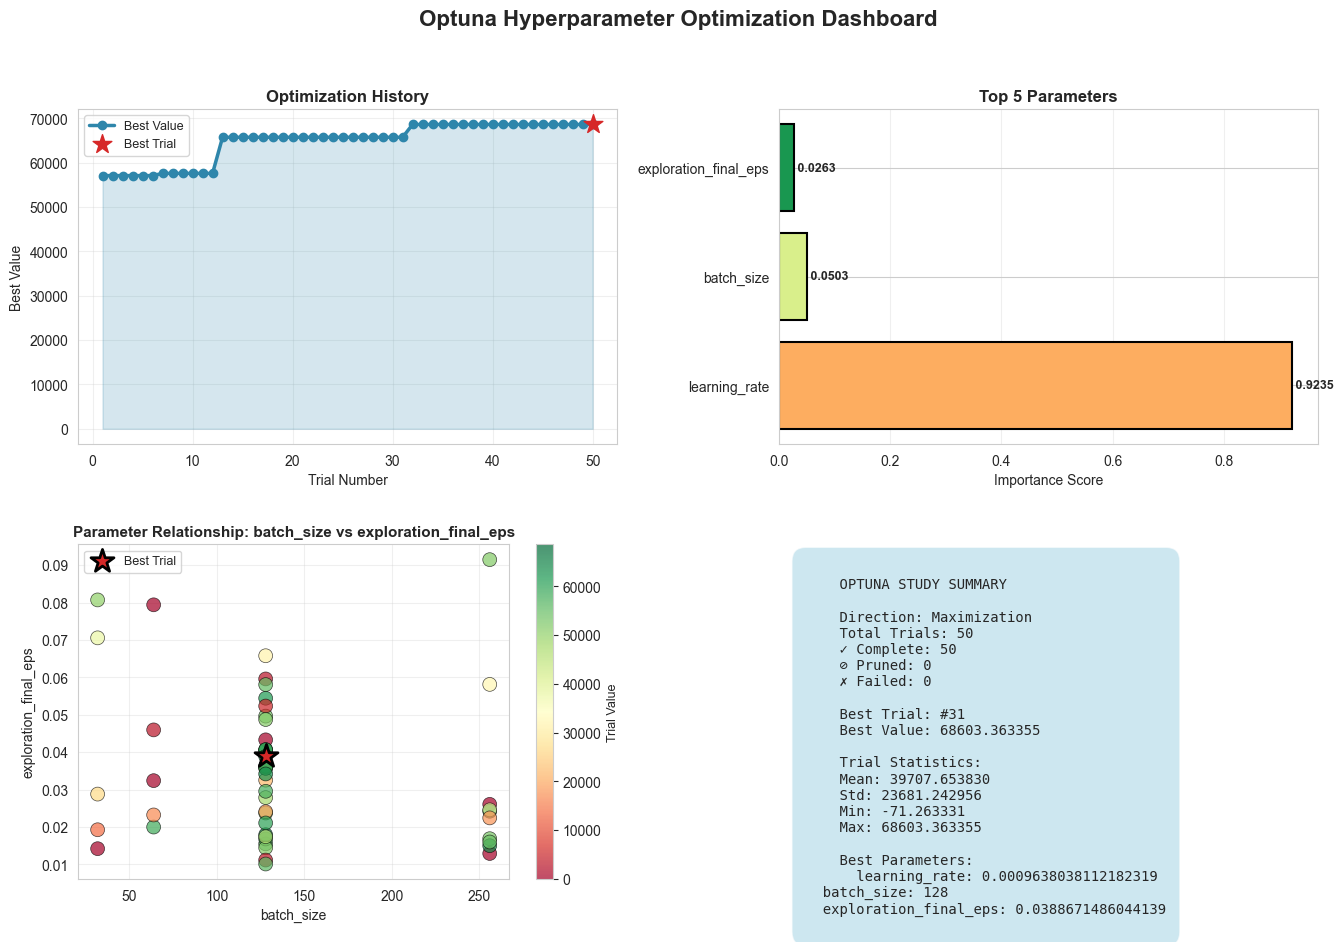

In [14]:
# Visualize the Optuna study results
create_optuna_study_dashboard(study)


In [6]:
# Train with best hyperparameters and evaluate across multiple seeds
TRAIN_CONFIG["learning_rate"] = 0.0009638038112182319
TRAIN_CONFIG["batch_size"] = 128
TRAIN_CONFIG["exploration_final_eps"] = 0.0388671486044139
TRAIN_CONFIG["total_timesteps"] = 1000000

seed_rewards = []

for seed_idx in range(5):
    np.random.seed(seed_idx)
    random.seed(seed_idx)
    
    # Re-initialize environments with new seed
    train_env = DQNWrapper(train_env_raw, reward_shape=REWARD_SHAPING, num_actions=NUM_ACTIONS)
    train_env.reset(seed=seed_idx)
    
    val_env = DQNWrapper(val_env_raw, reward_shape=REWARD_SHAPING, num_actions=NUM_ACTIONS)
    val_env.reset(seed=seed_idx)
    
    # Create and train model
    policy_kwargs = dict(net_arch=[256, 256, 128])
    model = DQN(
        "MlpPolicy",
        train_env,
        verbose=1,
        learning_rate=TRAIN_CONFIG["learning_rate"],
        buffer_size=TRAIN_CONFIG["buffer_size"],
        learning_starts=TRAIN_CONFIG["learning_starts"],
        batch_size=TRAIN_CONFIG["batch_size"],
        train_freq=TRAIN_CONFIG["train_freq"],
        gradient_steps=TRAIN_CONFIG["gradient_steps"],
        target_update_interval=TRAIN_CONFIG["target_update_interval"],
        gamma=TRAIN_CONFIG["gamma"],
        exploration_fraction=TRAIN_CONFIG["exploration_fraction"],
        exploration_initial_eps=TRAIN_CONFIG["exploration_initial_eps"],
        exploration_final_eps=TRAIN_CONFIG["exploration_final_eps"],
        policy_kwargs=policy_kwargs,
    )
    
    # Train the model
    model.learn(total_timesteps=TRAIN_CONFIG["total_timesteps"], log_interval=10)
    
    # Evaluate on validation environment
    val_env.reset(seed=seed_idx)
    val_env.reward_shape = False
    
    obs, _ = val_env.reset(seed=seed_idx)
    obs = np.array(obs, dtype=np.float32)
    done = False
    episode_rewards = []
    water_levels = []
    action_history = []
    
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        action = int(action)
        obs, reward, terminated, truncated, _ = val_env.step(action)
        done = terminated or truncated
        episode_rewards.append(reward)
        water_levels.append(val_env.env.volume)
        action_history.append(action)
        obs = np.array(obs, dtype=np.float32)
    
    total_reward = sum(episode_rewards)
    seed_rewards.append(episode_rewards)
    
    print(f"Seed {seed_idx + 1} - Total reward: {total_reward:.2f}")

# Save the best model
model.save("dqn_model_5bins_reward_shaping")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 2.63e+04  |
|    ep_rew_mean      | -2.32e+05 |
|    exploration_rate | 0.157     |
| time/               |           |
|    episodes         | 10        |
|    fps              | 2141      |
|    time_elapsed     | 122       |
|    total_timesteps  | 263030    |
| train/              |           |
|    learning_rate    | 0.000964  |
|    loss             | 15.7      |
|    n_updates        | 64507     |
-----------------------------------
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 2.63e+04  |
|    ep_rew_mean      | -1.93e+04 |
|    exploration_rate | 0.0389    |
| time/               |           |
|    episodes         | 20        |
|    fps              | 1946      |
|    time_elapsed     | 270       |
|    total_timesteps  | 526060    |
| trai

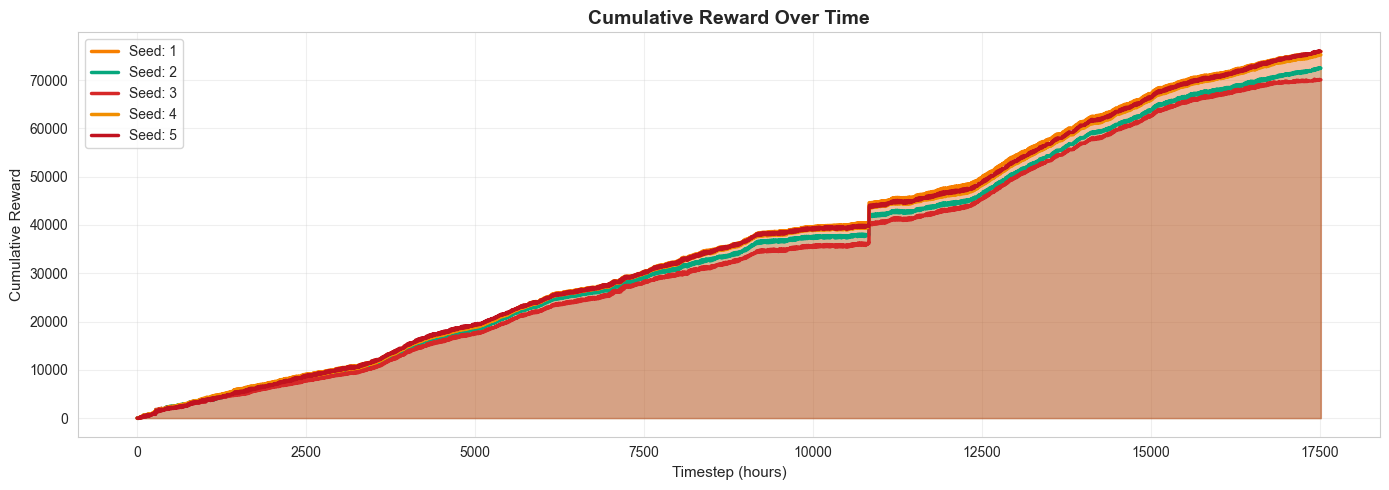

In [7]:
seed_results = {
    "Seed: 1" :seed_rewards[0],
    "Seed: 2" : seed_rewards[1],
    "Seed: 3" : seed_rewards[2],
    "Seed: 4" : seed_rewards[3],
    "Seed: 5" : seed_rewards[4]
}
plot_cumulative_rewards(seed_results)


### Model Performance

We visualize the performance of the model using multiple visualizations.


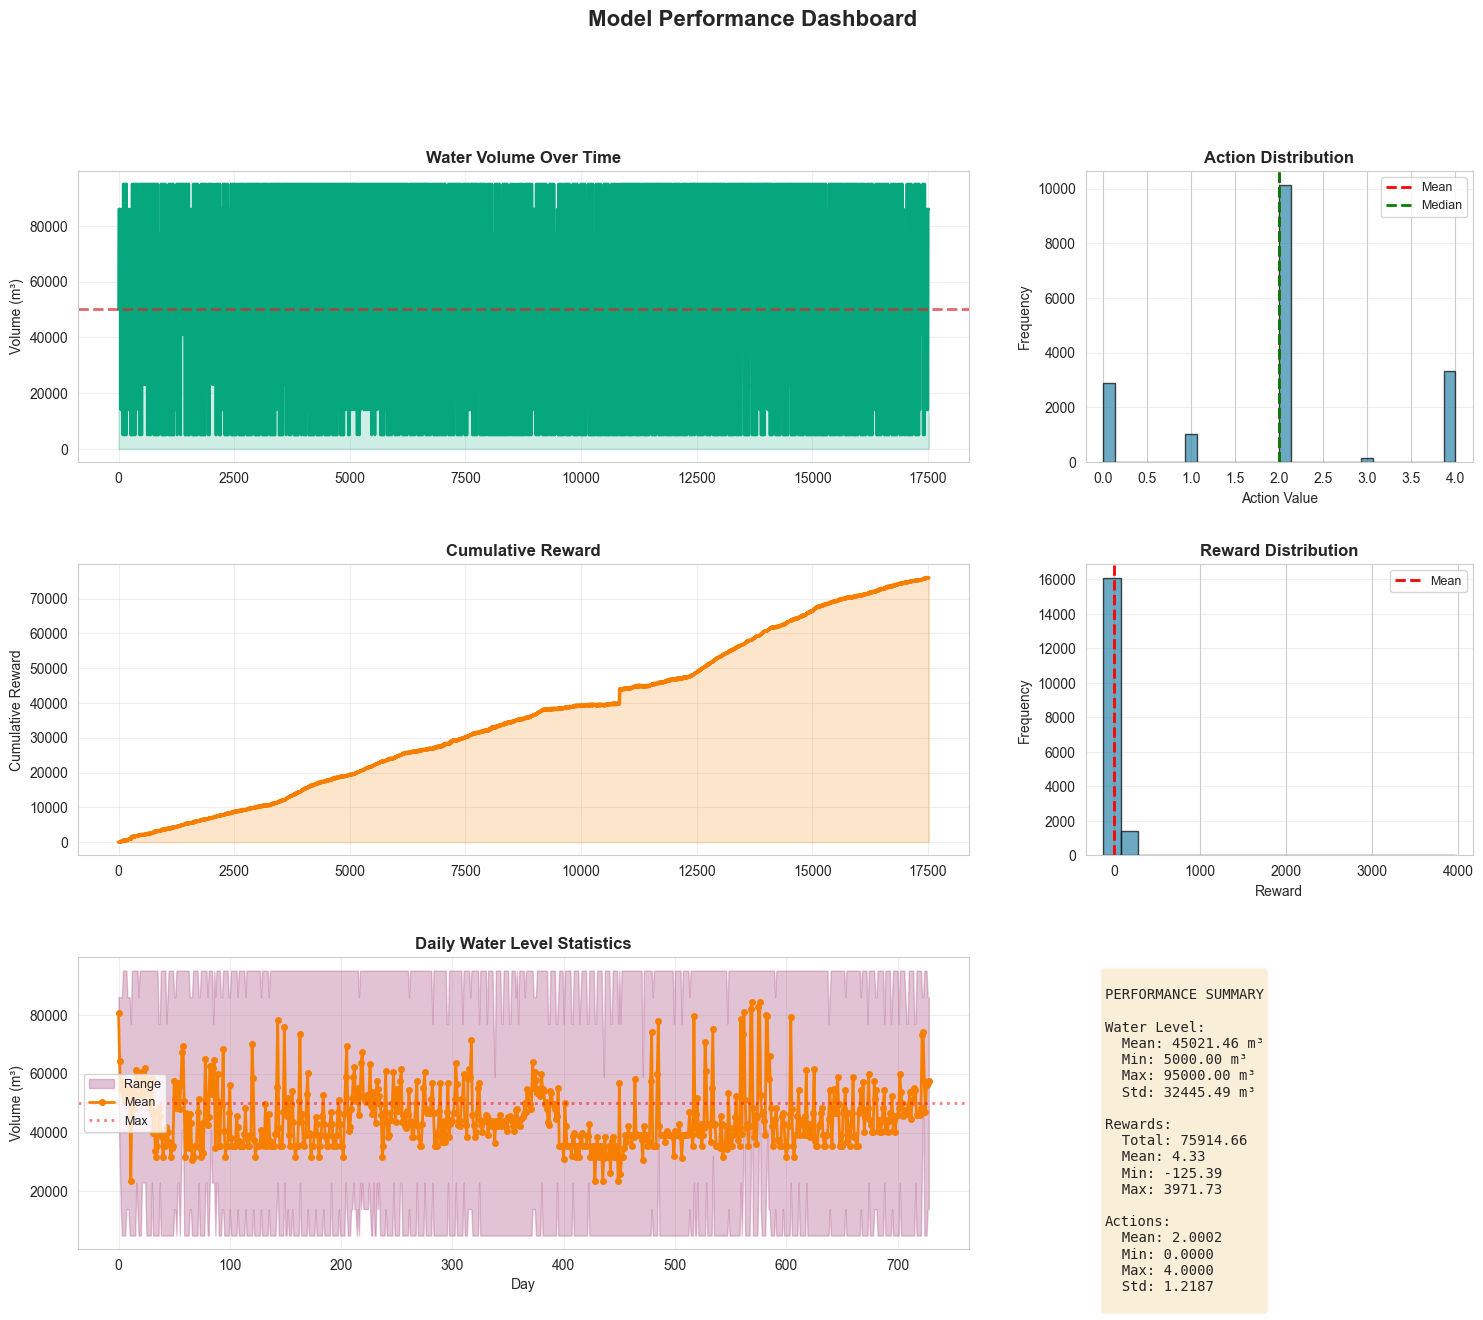

In [8]:
# Create comprehensive performance dashboard using the last trained model
create_performance_dashboard(water_levels, episode_rewards, action_history, max_volume=50000)
